In [1]:
%%capture
!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
!apt-get install python-numpy python-scipy -y
!pip install rasterio
!pip install fiona
!pip install geopandas
import gdal 

In [2]:
from tqdm.autonotebook import tqdm
from descartes import PolygonPatch
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import pandas as pd
import numpy as np
import geopandas
import os
import fiona

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
stats_pkl = "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Classification_statistics.pkl"
class_stats = pd.read_pickle(stats_pkl)
cur = class_stats.iloc[0]

In [5]:
def fix_shp(filename):
    shp = geopandas.read_file(filename)
    for index, feature in tqdm(shp.iterrows()):
        if feature["DN"] == 0:
            shp.drop(index, inplace=True)
    shp.to_file(filename)
    return shp

In [55]:
from rasterio.enums import Resampling

def downsample_image(file):
    with rasterio.open(file) as dataset:
    # resample data to target shape
        resampled = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * downscale_factor),
                int(dataset.width * downscale_factor)
            ),
            resampling=Resampling.nearest
        )

        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / resampled.shape[-1]),
            (dataset.height / resampled.shape[-2])
        )

    rasterio.plot.show(resampled)
    if dataset.count > 1:
        resampled = resampled.squeeze()
    print(resampled.shape)
    output = "downsampled_" + file
    with rasterio.open(output,'w',driver='GTiff',height=int(dataset.height * downscale_factor),width=int(dataset.width * downscale_factor),count=dataset.count,dtype=resampled.dtype,crs='+proj=latlong',transform=transform,) as dst:
        dst.write(resampled)

Fixing Shapfile of m_skr_2019-05_site04_120m_RGB.tif
Downsampling m_skr_2019-05_site04_120m_RGB.tif


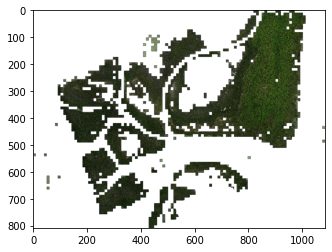

(4, 808, 1085)
Fixing Shapfile of prob_skr_2019-05_site04_120m_RGB.tif
Downsampling prob_skr_2019-05_site04_120m_RGB.tif


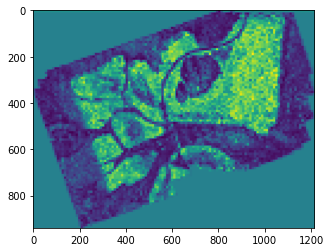

(1, 939, 1215)
Fixing Shapfile of nm_skr_2019-05_site06_120m_RGB.tif



Downsampling nm_skr_2019-05_site06_120m_RGB.tif


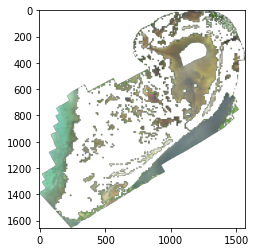

(4, 1656, 1564)
Fixing Shapfile of m_skr_2019-05_site06_120m_RGB.tif
Downsampling m_skr_2019-05_site06_120m_RGB.tif


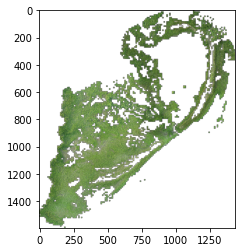

(4, 1597, 1433)
Fixing Shapfile of prob_skr_2019-05_site06_120m_RGB.tif
cp: error reading "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Orthomosaics/2019-05 Sian Ka'an Reserve/skr_2019-05_site06_120m_RGB_classifications/prob_skr_2019-05_site06_120m_RGB.tif": Input/output error
Downsampling prob_skr_2019-05_site06_120m_RGB.tif


RasterioIOError: ignored

In [56]:
downscale_factor = 1/25


for root, dirs, files in os.walk("/content/drive/Shared drives/SIO and E4E Mangroves /Data/Orthomosaics/"):
    for file in files:
        if not(("dem" in file) or ("DEM" in file))  and not(file.startswith("un_")) and not(file.startswith("downsampled_")) and (file.endswith(".tif")):
            dest_file = "downsampled_" + file
            full_path = os.path.join(root,file)
            folder = os.path.dirname(full_path)
            dest = os.path.join(folder, dest_file)

            if not(os.path.isfile(dest)):
                print("Fixing Shapfile of {}".format(file))
                if file.startswith("nm_"):
                    shapefile = os.path.splitext(full_path)[0] + ".shp"
                    shp = fix_shp(shapefile)
                print("Downloading {}".format(file))
                !cp {"\"" + full_path + "\""} . 
                
                print("Downsampling {}".format(file))
                downsample_image(file)    
                dest_file = "downsampled_" + file
                !cp {dest_file} {"\"" + dest + "\""}
                !rm *.tif 